In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('restaurant_data_guwahati.csv')

# Some EDA

In [6]:
df.head()

,name,coordinates,average_rating,number_of_ratings
0,Quick Kitchen,"(26.107517, 91.616328)",2.0,658
1,Golden Bakery,"(26.130371, 91.789294)",3.5,584
2,Happy Bakery,"(26.21307, 91.774535)",3.8,29
3,Quick Tavern,"(26.150731, 91.839227)",2.2,770
4,Tasty Cafe,"(26.150801, 91.696938)",2.4,143


In [4]:
test_df = df

In [9]:
test_df.at[0, 'coordinates']

'(26.107517, 91.616328)'

#### Converting all co-ordinates from strings to floating point tuples

In [5]:
# test_df.at[0, 'coordinates']
lat = []
long = []
for i in range(test_df.shape[0]):
    val = test_df.at[i, 'coordinates']
    j = 0
    while j < len(val):
        if val[j]==',':
            break
        j += 1
    
    lat.append(np.float64(val[1:j]))
    long.append(np.float64(val[j+2:-1]))


In [6]:
test_df['lat'] = lat
test_df['long'] = long

In [67]:
max_c = [25.0, 90.0]
min_c = [27.0, 93.0]
for i in range(test_df.shape[0]):
    c = test_df.at[i, 'coordinates']
    if c[0] > max_c[0]:
        max_c[0] = c[0]
    if c[0] < min_c[0]:
        min_c[0] = c[0]

    if c[1] > max_c[1]:
        max_c[1] = c[1]
    if c[1] < min_c[1]:
        min_c[1] = c[1]

In [66]:
max_c, min_c

([26.229162, 91.849942], [26.081007, 91.0])

#### Plotting coordinates

In [7]:
import plotly.express as px
import pandas as pd

# color_scale = [(0, 'orange')]
#zoom = getBoundsZoomLevel([26.229162, 91.849942, 26.081007, 91.0])
fig = px.scatter_mapbox(test_df, 
                        lat="lat", 
                        lon="long", 
                        hover_name="name", 
                        # hover_data=["Address", "Listed"],
                        # color="Listed",
                        # color_continuous_scale=color_scale,
                        # size="Listed",
                        zoom=10, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [8]:
test_df.head()

,name,coordinates,average_rating,number_of_ratings,lat,long
0,Quick Kitchen,"(26.107517, 91.616328)",2.0,658,26.107517,91.616328
1,Golden Bakery,"(26.130371, 91.789294)",3.5,584,26.130371,91.789294
2,Happy Bakery,"(26.21307, 91.774535)",3.8,29,26.213070,91.774535
3,Quick Tavern,"(26.150731, 91.839227)",2.2,770,26.150731,91.839227
4,Tasty Cafe,"(26.150801, 91.696938)",2.4,143,26.150801,91.696938


In [11]:
test_df.drop(['coordinates'], axis=1, inplace=True)

In [12]:
test_df.head()

,name,average_rating,number_of_ratings,lat,long
0,Quick Kitchen,2.0,658,26.107517,91.616328
1,Golden Bakery,3.5,584,26.130371,91.789294
2,Happy Bakery,3.8,29,26.213070,91.774535
3,Quick Tavern,2.2,770,26.150731,91.839227
4,Tasty Cafe,2.4,143,26.150801,91.696938


# Centroid based clustering

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import folium
import matplotlib.pyplot as plt

Silhouette Score: 0.2981323706249974
Cluster Centers (scaled):
[[-1.01602548 -0.23996759 -0.6049846 ]
 [-0.60792212  0.6951126   1.08332797]
 [ 0.60079931 -1.14845086 -0.96459914]
 [ 0.9684714  -0.63756821  0.64852427]
 [ 0.67457147  1.08902838 -0.79708623]]


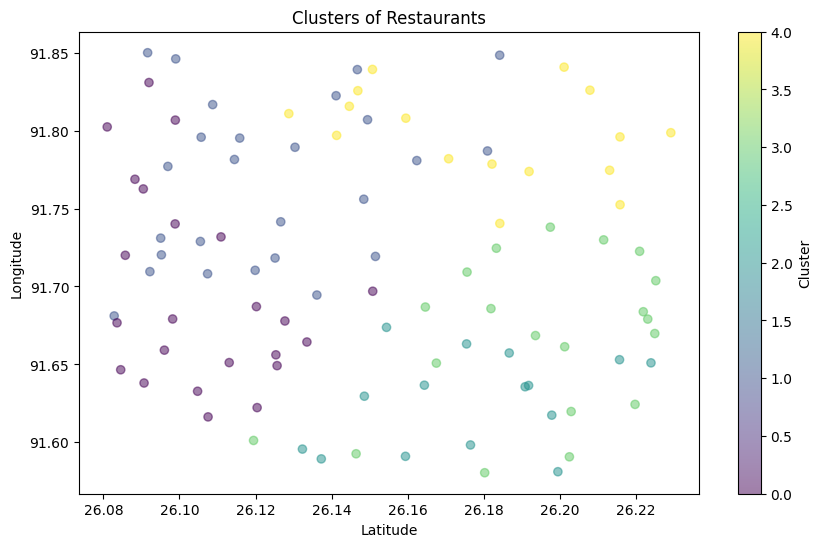

In [17]:
# calculating a success score:
test_df['success_score'] = test_df['average_rating'] * np.log1p(test_df['number_of_ratings'])
features = test_df[['lat', 'long', 'success_score']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Clustering using K-Means
k = 5  # Number of clusters (can be adjusted)
kmeans = KMeans(n_clusters=k, random_state=42)
test_df['cluster'] = kmeans.fit_predict(scaled_features)

# Evaluate clustering with Silhouette Score
silhouette_avg = silhouette_score(scaled_features, test_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Visualize clusters on a map
# Initialize the map centered around the mean latitude and longitude
map_center = [test_df['lat'].mean(), test_df['long'].mean()]
cluster_map = folium.Map(location=map_center, zoom_start=12)

# Add points to the map
colors = ['red', 'blue', 'green', 'purple', 'orange']  # Add more if k > 5
for i, row in test_df.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['long']),
        radius=5,
        color=colors[row['cluster']],
        fill=True,
        fill_color=colors[row['cluster']],
        fill_opacity=0.7
    ).add_to(cluster_map)

# Save the map to an HTML file
cluster_map.save("cluster_map.html")

# Display cluster centers
print("Cluster Centers (scaled):")
print(kmeans.cluster_centers_)

# Optional: Plot clusters on a 2D scatter plot (latitude vs longitude)
plt.figure(figsize=(10, 6))
plt.scatter(test_df['lat'], test_df['long'], c=test_df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Clusters of Restaurants')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Cluster')
plt.show()

In [18]:
# now that we have clusters, how to identify which cluster has greatest success score?
original_centers = scaler.inverse_transform(kmeans.cluster_centers_) # this will reverse standard scaling
print("Cluster Centers (original scale):")
print(original_centers)

Cluster Centers (original scale):
[[26.10557965 91.69638704  9.39145442]
 [26.12360046 91.76748112 25.00591958]
 [26.17697453 91.62731513  6.06553669]
 [26.19321    91.6661575  20.98461013]
 [26.18023212 91.7974305   7.61479044]]


In [ ]:
# average success scores in a cluster - same as centroid obviously
cluster_scores = test_df.groupby('cluster')['success_score'].mean()
print("Average Success Score by Cluster:")
print(cluster_scores)

Average Success Score by Cluster:
cluster
0     9.391454
1    25.005920
2     6.065537
3    20.984610
4     7.614790
Name: success_score, dtype: float64


### lat and long associated with centroid of cluser 1 is the optimal location to start a restuarant